In [8]:
import pandas as pd
import numpy as np 
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

df_train=readDataFromFile('../../homework/training_data_20210302.csv')
df_train = df_train.loc[df_train['TOOLG_ID']=='PK_DUVKrF']
# 觀察缺失值------------------------------------------
print(df_train.isnull().sum())
# 做数据切分------------------------------------------
print(df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1).describe())
df_train_eh =df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1) 
X_dropped = np.asarray(df_train_eh)
Y_dropped = np.asarray(df_train['MOVE_QTY'])

X_train, X_val, y_train, y_val = train_test_split(X_dropped, Y_dropped, random_state=1)
xgTrain = xgb.DMatrix(X_train,y_train)
xgVal = xgb.DMatrix(X_val,y_val)

#調超參 best_nround-----------------------------------------------------------
 
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
num_round = 10
best_nround = 1000

# bst = xgb.train(param, dtrain, num_round)
# 设定watchlist用于查看模型状态
watchlist  =[(xgTrain, 'train'), (xgVal, 'valid')]

res = xgb.cv(other_params,xgTrain,num_boost_round=500,metrics='rmse',early_stopping_rounds=25)
# #找到最佳迭代轮数
best_nround = res.shape[0] - 1
print('找到最佳迭代轮数',best_nround)


bst = xgb.train(other_params, xgTrain, best_nround, watchlist)

# # 使用模型预测
# preds = bst.predict(xgtest)

# # 判断准确率
# labels = xgtest.get_label()
# print('错误类为%f' % \
#     (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))


MFG_DATE       0
TOOLG_ID       0
WIP_QTY        0
NO_HOLD_QTY    0
MOVE_QTY       0
M              0
U              0
PT             0
UP_TIME        0
EQP_UTIL       0
TC             0
CS             0
AI             0
C_AI           0
dtype: int64
            WIP_QTY   NO_HOLD_QTY           M           U           PT  \
count    401.000000    401.000000  401.000000  401.000000   401.000000   
mean   15649.438903  14153.817955   30.710723    0.069952  2991.323249   
std     3268.166719   3199.797732    2.598290    0.058100    64.123117   
min     3163.000000   2805.000000    2.000000    0.033333  2821.530355   
25%    13475.000000  12024.000000   30.000000    0.063549  2949.116780   
50%    15328.000000  13833.000000   31.000000    0.065769  2988.247734   
75%    17406.000000  15948.000000   32.000000    0.068811  3027.918790   
max    31335.000000  29847.000000   32.000000    1.101804  3353.320665   

          UP_TIME    EQP_UTIL          TC          CS        C_AI  
count  401.000

In [9]:
cols=['M','U','PT','UP_TIME','EQP_UTIL','TC','CS','C_AI']
df_testing = df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1)
df_testing[cols]= df_testing[cols].mean()
df_testing =df_testing[0:1]
# max_wip = df_testing['NO_HOLD_QTY'].max()* .75
max_wip = np.percentile(df_testing['NO_HOLD_QTY'], 50) # return 50th percentile, e.g median.
tick = (df_testing['NO_HOLD_QTY'].max() - df_testing['NO_HOLD_QTY'].min()) /400
if max_wip <=0 :
    max_wip=100
if tick <10 :
    tick = 10
print(max_wip,tick)

df = pd.DataFrame(columns = df_testing.columns)

for i in range(1000):
    df_testing['NO_HOLD_QTY']=max_wip+ tick*i
    df = df.append(df_testing,ignore_index=True)
print(df.shape,df.head())        
# TestModel(df,save_model)
#TestModelXG(df,save_modelxg)

17474.0 10
(1000, 10)    WIP_QTY  NO_HOLD_QTY          M         U           PT   UP_TIME  EQP_UTIL  \
0  19000.0      17474.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
1  19000.0      17484.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
2  19000.0      17494.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
3  19000.0      17504.0  30.710723  0.069952  2991.323249  0.950456    0.9732   
4  19000.0      17514.0  30.710723  0.069952  2991.323249  0.950456    0.9732   

         TC        CS      C_AI  
0  0.505878  0.297117  0.269249  
1  0.505878  0.297117  0.269249  
2  0.505878  0.297117  0.269249  
3  0.505878  0.297117  0.269249  
4  0.505878  0.297117  0.269249  


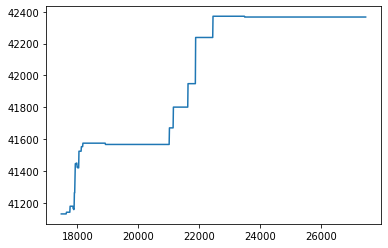

In [11]:
X_droppedtest = np.asarray(df)
xgtest = xgb.DMatrix(X_droppedtest)
# y_predict = optimized_GBM.predict(dtest)

# # 使用模型预测
y_predict = bst.predict(xgtest)

# # 判断准确率
# labels = xgtest.get_label()
# print('错误类为%f' % \
#     (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))
df['predict'] = y_predict

plt.plot(df['NO_HOLD_QTY'] , y_predict)
plt.show()